In [1]:
import re
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cycler
import seaborn as sns
import numpy as np
from IPython.display import HTML

In the first pass, we do a rough tokenization of the authentication log. We don't actually know how many different 'auth_source' types to expect, so we need to do some analysis to understand this better.

# Read the logs and do first coarse parsing

In [2]:
auth_parse = '^([A-Z][a-z]{2} [0-9\ ]\d \d{2}:\d{2}:\d{2}) ([a-z0-9A-Z][a-zA-Z0-9-]{0,62}) ([^:]+): (.*)$'
auth = []
with open("./all_auth_logs.txt") as f:
  lines = f.readlines()
  for line in lines:
    m = re.findall(auth_parse, line)
    auth_d = {
      'timestamp': dt.datetime.strptime(m[0][0], '%b %d %H:%M:%S').replace(year=2020),
      'hostname': m[0][1],
      'auth_source': m[0][2],
      'message': m[0][3]
    }
    auth.append(auth_d)

In [3]:
df = pd.DataFrame(auth)
df['auth_type'] = ''
df['auth_pid'] = -1

# Parse out the different auth sources

In [4]:
ssh_idx = df['auth_source'].str.startswith('sshd')
df.loc[ssh_idx, 'auth_type'] = 'ssh'
df.loc[ssh_idx, 'auth_pid'] = df.loc[ssh_idx, 'auth_source'].apply(lambda x: re.findall('sshd\[(\d+)\]',x)[0])

cron_idx = df['auth_source'].str.startswith('CRON')
df.loc[cron_idx, 'auth_type'] = 'cron'
df.loc[cron_idx, 'auth_pid'] = df.loc[cron_idx, 'auth_source'].apply(lambda x: re.findall('CRON\[\d+\]', x)[0])

login_idx = df['auth_source'].str.startswith('systemd-logind')
df.loc[login_idx, 'auth_type'] = 'physical_login'
df.loc[login_idx, 'auth_pid'] = df.loc[login_idx, 'auth_source'].apply(lambda x: re.findall('systemd-logind\[(\d+)\]', x)[0])

gnome_keyring = df['auth_source'].str.startswith('gnome-keyring-daemon')
df.loc[gnome_keyring, 'auth_type'] = 'gnome_keyring'
df.loc[gnome_keyring, 'auth_pid'] = df.loc[gnome_keyring, 'auth_source'].apply(lambda x: re.findall('gnome-keyring-daemon\[(\d+)\]', x)[0])

pkexec = df['auth_source'].str.startswith('pkexec')
df.loc[pkexec, 'auth_type'] = 'pkexec'

systemd = df['auth_source'].str.startswith('systemd')
df.loc[systemd, 'auth_type'] = 'physical_login'

polkitid = df['auth_source'].str.startswith('polk')
df.loc[polkitid, 'auth_type'] = 'polk'

gdm_password = df['auth_source'].str.startswith('gdm-password')
df.loc[gdm_password, 'auth_type'] = 'gdm_pass'

sudo = df['auth_source'].str.startswith('sudo')
df.loc[sudo, 'auth_type'] = 'sudo'

sudo = df['auth_source'].str.startswith('dbus')
df.loc[sudo, 'auth_type'] = 'dbus'

gdm = df['auth_source'].str.startswith('gdm-launch-env')
df.loc[gdm, 'auth_type'] = 'gdm-launch'

su = df['auth_source'].str.startswith('su[')
df.loc[su, 'auth_type'] = 'switch_user'

df.loc[df['auth_type'] == '', 'auth_type'] = 'other'

In [5]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid
0,2020-10-18 00:10:16,computer,sshd[3407],Did not receive identification string from 129...,ssh,3407
1,2020-10-18 00:10:16,computer,sshd[3408],Bad protocol version identification '\026\003\...,ssh,3408
2,2020-10-18 00:17:01,computer,CRON[3414],pam_unix(cron:session): session opened for use...,cron,CRON[3414]
3,2020-10-18 00:17:01,computer,CRON[3414],pam_unix(cron:session): session closed for use...,cron,CRON[3414]
4,2020-10-18 00:23:22,computer,sshd[3420],pam_unix(sshd:auth): authentication failure; l...,ssh,3420
...,...,...,...,...,...,...
147198,2020-09-27 00:09:05,computer,sshd[4052],pam_unix(sshd:auth): authentication failure; l...,ssh,4052
147199,2020-09-27 00:09:07,computer,sshd[4050],Failed password for root from 218.92.0.246 por...,ssh,4050
147200,2020-09-27 00:09:07,computer,sshd[4052],Failed password for invalid user 13.251.43.182...,ssh,4052
147201,2020-09-27 00:09:07,computer,sshd[4052],Received disconnect from 40.121.89.73 port 369...,ssh,4052


# Parse the interesting stuff - ssh

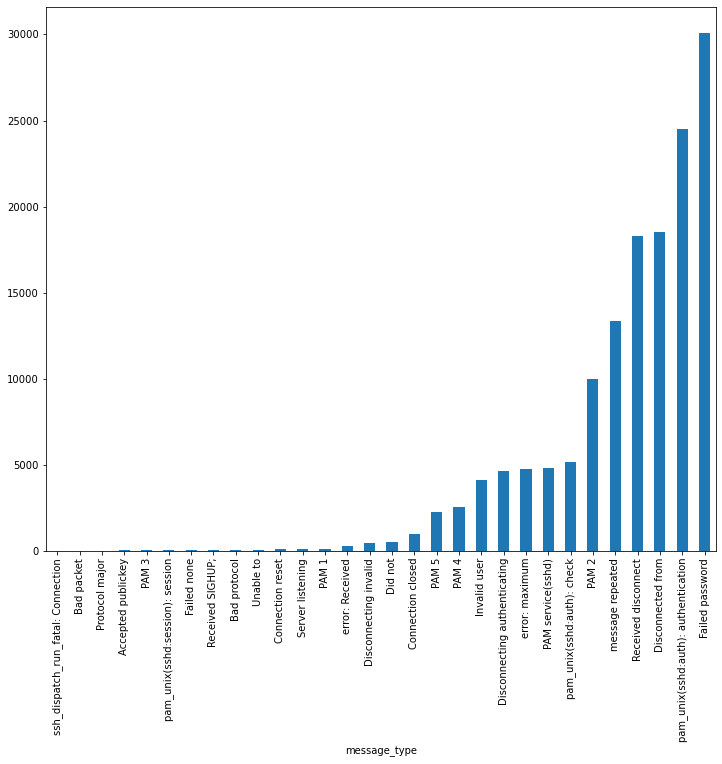

In [6]:
# Get a sense for the message types:
ssh_df = df[df['auth_type'] == 'ssh'].copy(deep=True)
ssh_df['message_type'] = ssh_df['message'].apply(lambda x: ' '.join(x.split(' ')[0:2]))
fig, ax = plt.subplots(figsize=(12, 10))
ssh_df.groupby('message_type').count()['hostname'].sort_values().plot.bar(ax=ax)

In [7]:
ssh_df['message_type'].value_counts() / ssh_df['message_type'].value_counts().sum()

Failed password                        0.206348
pam_unix(sshd:auth): authentication    0.167940
Disconnected from                      0.127193
Received disconnect                    0.125458
message repeated                       0.091653
PAM 2                                  0.068529
pam_unix(sshd:auth): check             0.035232
PAM service(sshd)                      0.032995
error: maximum                         0.032776
Disconnecting authenticating           0.031658
Invalid user                           0.028248
PAM 4                                  0.017568
PAM 5                                  0.015304
Connection closed                      0.006647
Did not                                0.003560
Disconnecting invalid                  0.003286
error: Received                        0.001736
PAM 1                                  0.000734
Server listening                       0.000686
Connection reset                       0.000624
Unable to                              0

In [8]:
for message in ssh_df[ssh_df['message'].str.startswith('pam_unix(sshd:auth)')]['message'][0:20]:
  print(message)

pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=183.234.58.41  user=root
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=185.220.101.203
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=213.108.218.84  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=213.108.218.84  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=213.108.218.84  user=root
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=213.108.218.84
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:au

It seems like the vast majority of the logs we're getting from auth is coming from failed SSH attempts. Lets look at some of them.

In [9]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(message)

Failed password for root from 183.234.58.41 port 40770 ssh2
Failed password for root from 183.234.58.41 port 40770 ssh2
Failed password for invalid user admin from 185.220.101.203 port 31824 ssh2
Failed password for root from 213.108.218.84 port 24317 ssh2
Failed password for root from 213.108.218.84 port 29381 ssh2
Failed password for root from 213.108.218.84 port 31519 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 32597 ssh2
Failed password for invalid user admin from 213.108.218.84 port 35033 ssh2
Failed password for invalid user admin from 213.108.218.84 port 35033 ssh2
Failed password for i

In [10]:
parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'

In [11]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_invalid, message))

[]
[]
[('admin', '185.220.101.203', '31824')]
[]
[]
[]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '32597')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '35033')]
[('admin', '213.108.218.84', '37333')]
[('admin', '213.108.218.84', '37333')]


In [12]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_valid, message))

[('root', '183.234.58.41', '40770')]
[('root', '183.234.58.41', '40770')]
[]
[('root', '213.108.218.84', '24317')]
[('root', '213.108.218.84', '29381')]
[('root', '213.108.218.84', '31519')]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Looks like its working - lets pull out all failed login attempts and understand what's going on here.

In [13]:
fail_df = ssh_df[ssh_df['message'].str.startswith('Failed')].copy(deep=True)

In [14]:
def parse_message(message):
  message = message['message']
  
  parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'
  parse_none    = r'^Failed none for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_blank_1 = r'^Failed none for invalid user  from (\S+) port (\S+) ssh2$'
  parse_blank_2 = r'^Failed password for invalid user  from (\S+) port (\S+) ssh2$'
  
  m1 = re.findall(parse_invalid, message)
  m2 = re.findall(parse_valid, message)
  m3 = re.findall(parse_none, message)
  m4 = re.findall(parse_blank_1, message)
  m5 = re.findall(parse_blank_2, message)
  
  user = ''
  source_ip = ''
  port = ''
  
  try:
    user = m1[0][0]
    source_ip = m1[0][1]
    port = m1[0][2]
  except IndexError:
    try:
      user = m2[0][0]
      source_ip = m2[0][1]
      port = m2[0][2]
    except IndexError:
      try:
        user = m3[0][0]
        source_ip = m3[0][1]
        port = m3[0][2]
      except:
        try:
          user = 'none'
          source_ip = m4[0][0]
          port = m4[0][1]
        except:
          try:
            user = 'none'
            source_ip = m5[0][0]
            port = m5[0][1]
          except:
            pass
  
  return user, source_ip, port

message = fail_df.apply(func=parse_message, axis=1, result_type='expand').rename(columns={0:'user', 1:'source_ip', 2:'port'})

In [15]:
df = pd.concat([fail_df, message], axis=1) 

In [16]:
df[df['user'] == '']['message']

Series([], Name: message, dtype: object)

In [17]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid,message_type,user,source_ip,port
5,2020-10-18 00:23:24,computer,sshd[3420],Failed password for root from 183.234.58.41 po...,ssh,3420,Failed password,root,183.234.58.41,40770
6,2020-10-18 00:23:26,computer,sshd[3420],Failed password for root from 183.234.58.41 po...,ssh,3420,Failed password,root,183.234.58.41,40770
13,2020-10-18 00:29:49,computer,sshd[3426],Failed password for invalid user admin from 18...,ssh,3426,Failed password,admin,185.220.101.203,31824
18,2020-10-18 00:43:55,computer,sshd[3437],Failed password for root from 213.108.218.84 p...,ssh,3437,Failed password,root,213.108.218.84,24317
25,2020-10-18 00:44:09,computer,sshd[3439],Failed password for root from 213.108.218.84 p...,ssh,3439,Failed password,root,213.108.218.84,29381
...,...,...,...,...,...,...,...,...,...,...
147181,2020-09-27 00:06:31,computer,sshd[4043],Failed password for root from 222.186.175.217 ...,ssh,4043,Failed password,root,222.186.175.217,23372
147185,2020-09-27 00:07:07,computer,sshd[4046],Failed password for root from 23.96.54.252 por...,ssh,4046,Failed password,root,23.96.54.252,15819
147189,2020-09-27 00:08:45,computer,sshd[4048],Failed password for root from 218.92.0.246 por...,ssh,4048,Failed password,root,218.92.0.246,48126
147199,2020-09-27 00:09:07,computer,sshd[4050],Failed password for root from 218.92.0.246 por...,ssh,4050,Failed password,root,218.92.0.246,11291


In [18]:
df['user'].value_counts()[df['user'].value_counts() > 6]

root          24862
admin           713
user            249
test            207
oracle          172
              ...  
master            8
butter            7
azureadmin        7
monitor           7
bad               7
Name: user, Length: 84, dtype: int64

In [19]:
# Pagate and view
rollover = 200

logins = df['user'].value_counts()\
  .sort_index()\
  .reset_index()\
  .rename(columns={'index':'login', 'user':'number'})

start_idx = 0
end_idx = rollover

pagated = []

while start_idx < len(logins):
  pagated.append(logins[start_idx:end_idx].reset_index().loc[:,['login', 'number']])
  start_idx += rollover
  end_idx += rollover
  
HTML(pd.concat(pagated, axis=1).to_html())

,login,number,login,number,login,number,login,number,login,number
0,!,1,benzinger,1,hadoop,53,oracle,172,tushar,1.0
1,!root,2,bestatto,1,handongmin,1,orangepi,2,tycoon,3.0
2,*****,1,betty,2,happy50,1,orgkhim,1,uamerica,1.0
3,0,2,bigipuser3,1,happynimo,1,osmc,5,ubadmin,2.0
4,101,2,bill,3,hass,1,otogi,1,ubnt,98.0
5,107,9,bin,5,hdfds,1,oxxodata,1,ubuntu,117.0
6,109,1,bisnode,1,hdfs,1,packages.interconnectit.com,1,uftp,6.0
7,110,4,bitcoin,2,helpdesk,2,padmin,1,unixcape,1.0
8,1111,3,bitrix,2,hemovita,1,pagestrip,1,unreal,1.0
9,11111,1,bkwonderhoud,1,hero,1,parkzippy,1,upperly,1.0


In [20]:
df_summary = pd.concat(
  [
    df[['source_ip', 'port']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'port':'num_ports_scanned'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').max().rename(columns={'timestamp':'max_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').min().rename(columns={'timestamp':'min_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').count().rename(columns={'timestamp':'number_of_attempts'}),
    df[['source_ip', 'user']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'user':'uname_count'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'timestamp':'timeseries'})
  ],
  axis=1
)
df_summary['ats'] = df_summary['number_of_attempts'] / (df_summary['max_timestamp'] - df_summary['min_timestamp']).apply(lambda x: x.total_seconds())
df_summary.sort_values(by='number_of_attempts', ascending=False).head(10)

,num_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,ats
source_ip,,,,,,,
218.92.0.205,2682,2020-10-23 16:25:12,2020-10-19 08:23:24,3422,1,"[2020-10-19 08:23:24, 2020-10-19 08:28:02, 202...",0.009137
218.92.0.210,2604,2020-09-24 20:23:31,2020-09-22 04:45:11,3327,1,"[2020-09-22 04:45:11, 2020-09-22 04:46:29, 202...",0.014522
122.194.229.3,2710,2020-10-10 19:22:22,2020-10-08 23:49:49,3137,1,"[2020-10-08 23:49:49, 2020-10-08 23:50:48, 202...",0.020012
218.92.0.204,1230,2020-10-19 08:08:03,2020-10-18 09:03:44,1554,1,"[2020-10-18 09:03:44, 2020-10-18 09:04:59, 202...",0.018710
31.184.198.75,302,2020-09-28 10:15:07,2020-09-21 08:00:51,701,134,"[2020-09-28 09:42:33, 2020-09-28 09:42:35, 202...",0.001144
218.92.0.192,395,2020-10-08 23:13:54,2020-10-07 20:54:22,404,1,"[2020-10-07 20:54:22, 2020-10-07 20:58:54, 202...",0.004263
31.184.199.114,139,2020-09-28 10:15:11,2020-09-21 08:01:10,332,89,"[2020-09-28 09:42:27, 2020-09-28 09:42:45, 202...",0.000542
111.43.41.18,294,2020-09-22 01:46:10,2020-09-21 23:58:12,294,101,"[2020-09-21 23:58:12, 2020-09-21 23:58:26, 202...",0.045384
61.177.172.13,202,2020-09-21 20:05:33,2020-09-21 03:25:13,275,1,"[2020-09-21 03:25:13, 2020-09-21 03:26:18, 202...",0.004582


In [21]:
!pip install ipwhois

In [61]:
from ipwhois import IPWhois
import os
import sys
import numpy as np
import time
import json

ip_country = {}

try:
  with open("ip_to_country_mapping.json", "r") as f:
    ip_country = json.load(f)
except:
  pass

for ip in df_summary.index.unique():
  if ip not in ip_country:
    print("processing", ip, "            ", end='\r')
    resp = IPWhois(ip)
    country = resp.lookup_whois()['asn_country_code']
    ip_country[ip] = country

with open("ip_to_country_mapping.json", "w") as f:
  json.dump(ip_country, f)

In [62]:
df_summary['country'] = pd.Series(ip_country)

Text(0.5, 1.0, 'Attacks by Country')

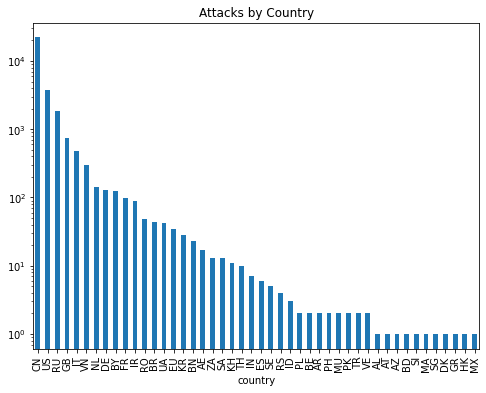

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False).plot.bar(ax=ax, logy=True)
ax.set_title("Attacks by Country")

In [75]:
df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False)[:3]

country
CN    22112
US     3712
RU     1853
Name: number_of_attempts, dtype: int64

In [72]:
# plt_df = df_summary.loc[df_summary.index == '218.92.0.205']
plt_df = df_summary
plt_df

n = len(plt_df)
color = plt.cm.jet(np.linspace(0, 1,n))

Text(0.5, 1.0, 'Attack History')

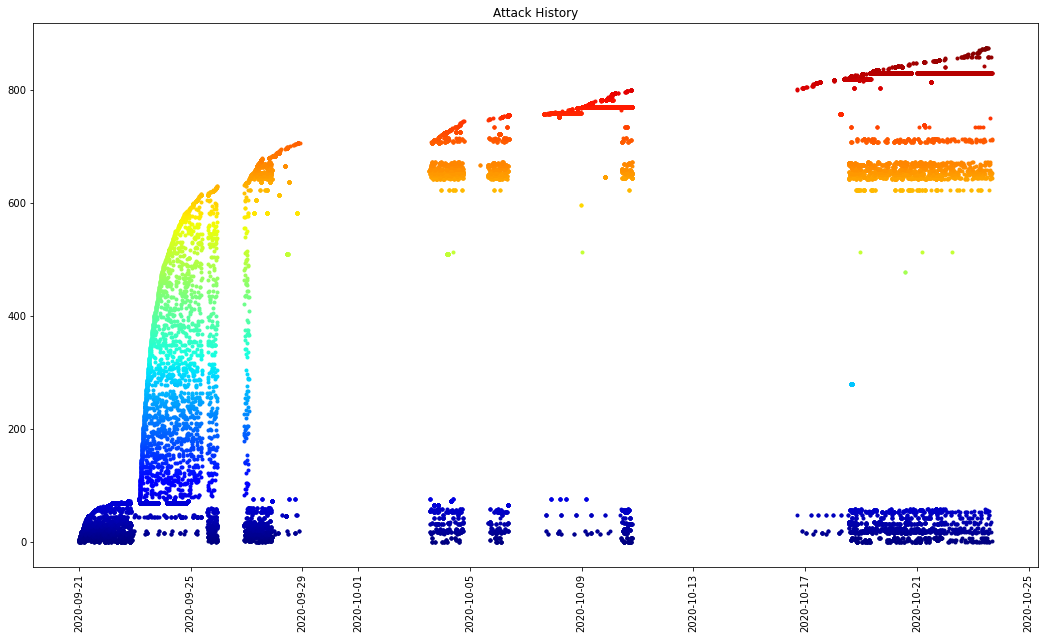

In [73]:
fig, ax = plt.subplots(figsize=(18,10))
plt.sca(ax)

for i, row in enumerate(plt_df.sort_values(by='min_timestamp').iterrows()):
  ip_address = row[0]
  data = row[1]
  timeseries = data['timeseries']
  
  plt.scatter(
    timeseries,
    np.full(shape=(len(timeseries),), fill_value=i),
    label=ip_address,
    marker='.',
    color=color[i],
  )
  plt.xticks(rotation='90')
plt.title("Attack History")